# RadarCOVID-Report

In [1]:
import matplotlib
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (15, 6)

## COVID-19 Cases

In [3]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")
confirmed_df = confirmed_df[confirmed_df["Country_EN"] == "Spain"]
confirmed_df = confirmed_df[pd.isna(confirmed_df["Region"])]
confirmed_df.drop(columns=["Country_EN", "Country_ES", "Country_IT", "Region"], inplace=True)
confirmed_df = confirmed_df.transpose()
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["rolling_mean_new_cases"] = confirmed_df.new_cases.rolling(7).mean()
confirmed_df.head()

,sample_date_string,cumulative_cases,new_cases,rolling_mean_new_cases
0,2020-01-23,0.0,NaN,NaN
1,2020-01-24,0.0,0.0,NaN
2,2020-01-25,0.0,0.0,NaN
3,2020-01-26,0.0,0.0,NaN
4,2020-01-27,0.0,0.0,NaN


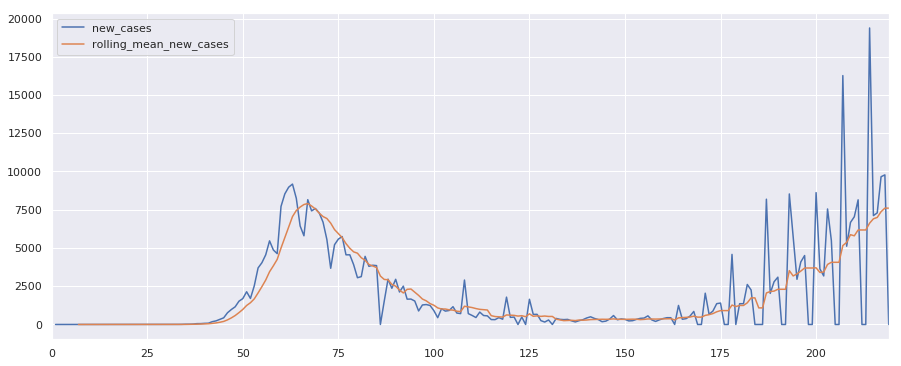

In [4]:
confirmed_df[["new_cases", "rolling_mean_new_cases"]].plot()

## RadarCOVID TEKs Extraction

In [5]:
from Modules.RadarCOVID import radar_covid

exposure_keys_df = radar_covid.download_last_radar_covid_exposure_keys(days=14)
exposure_keys_df[[
    "sample_date_string", "source_url", "region", "key_data"]].head()

,sample_date_string,source_url,region,key_data
0,2020-08-29,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,5cadde25-d2e9-6dd3-faae-e84777184052
1,2020-08-29,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,861ac698-ee7d-075c-393a-5c13763e4ff5
2,2020-08-29,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,43943f8d-4696-3507-3b8d-b7a59c9b533a
3,2020-08-29,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,d0c5f063-05e0-89a1-adb9-9f9e2880645a
4,2020-08-29,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,4f66bce5-0b8b-7e47-06b0-5dc6404157a3


In [6]:
exposure_keys_summary_df = \
    exposure_keys_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "tek_count"}, inplace=True)
exposure_keys_summary_df.head()

,tek_count
sample_date_string,
2020-08-29,12
2020-08-28,28
2020-08-27,54
2020-08-26,67
2020-08-25,57


## RadarCOVID TEKs Dump

In [7]:
import datetime

extraction_date = datetime.datetime.utcnow().strftime("%Y-%m-%d")
tek_list_df = exposure_keys_df[["sample_date_string", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    "sample_date").tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df.to_json(
    "Data/RadarCOVID-Report-" + extraction_date + ".json",
    lines=True, orient="records")
tek_list_df

,sample_date,tek_list,extraction_date
0,2020-08-19,[645572b7-c0e2-97bc-9bcb-7107fb5eb1bc],2020-08-30
1,2020-08-20,"[5c4885a2-5c65-d6aa-8eed-7d607f106647, e6c3ca3...",2020-08-30
2,2020-08-21,"[53c82402-7f1c-e203-7abc-593dc3a8a9fe, fd16f69...",2020-08-30
3,2020-08-22,"[316fcc1d-9bdb-69ae-b997-70b5b4ca1d74, 33b23da...",2020-08-30
4,2020-08-23,"[3dda2de2-fc66-33b9-cf6b-c7b85f8683d5, c0a53a0...",2020-08-30
5,2020-08-24,"[b040f48d-d3f9-6518-2b3d-24037d185437, bbc28f7...",2020-08-30
6,2020-08-25,"[2009e54d-a6af-bdf7-b028-3831bed75b9e, 8869928...",2020-08-30
7,2020-08-26,"[bc8260d0-6913-a6b6-f16a-380e8436cf79, 9ab2c4e...",2020-08-30
8,2020-08-27,"[0b04b620-b555-17b3-6ef4-7dc1f9cc960a, 6e8eb4a...",2020-08-30
9,2020-08-28,"[f4ae4dc9-2bf4-ccca-2c9f-dc095ab059b8, 757936a...",2020-08-30


## RadarCOVID New TEKs

In [8]:
import glob

tek_list_df = pd.DataFrame()

for path in glob.glob("Data/RadarCOVID-Report-*.json"):
    extraction_tek_list_df = pd.read_json(path, lines=True)
    tek_list_df = tek_list_df.append(extraction_tek_list_df, sort=False)
    
tek_list_df.head()

,sample_date,tek_list,extraction_date
0,2020-08-19,[645572b7-c0e2-97bc-9bcb-7107fb5eb1bc],2020-08-29
1,2020-08-20,"[5c4885a2-5c65-d6aa-8eed-7d607f106647, e6c3ca3...",2020-08-29
2,2020-08-21,"[53c82402-7f1c-e203-7abc-593dc3a8a9fe, fd16f69...",2020-08-29
3,2020-08-22,"[316fcc1d-9bdb-69ae-b997-70b5b4ca1d74, 33b23da...",2020-08-29
4,2020-08-23,"[3dda2de2-fc66-33b9-cf6b-c7b85f8683d5, c0a53a0...",2020-08-29


In [9]:
tek_list_df = tek_list_df.groupby("extraction_date").tek_list.apply(lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-08-29,"{b3076246-f401-fdc1-4910-e905c6d0b7ed, 4c5251d..."
2020-08-30,"{b3076246-f401-fdc1-4910-e905c6d0b7ed, 4c5251d..."


In [10]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "new_tek_count",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.head()

,sample_date_string,new_tek_count
0,2020-08-29,NaN
1,2020-08-30,16.0


## Data Merge

In [11]:
result_summary_df = exposure_keys_summary_df.merge(new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count
0,2020-08-29,12.0,NaN
1,2020-08-28,28.0,NaN
2,2020-08-27,54.0,NaN
3,2020-08-26,67.0,NaN
4,2020-08-25,57.0,NaN


In [12]:
result_summary_df = result_summary_df.merge(confirmed_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,cumulative_cases,new_cases,rolling_mean_new_cases
0,2020-08-29,12.0,NaN,439286.0,0.0,7604.571429
1,2020-08-28,28.0,NaN,439286.0,9779.0,7604.571429
2,2020-08-27,54.0,NaN,429507.0,9658.0,7371.571429
3,2020-08-26,67.0,NaN,419849.0,7296.0,6997.428571
4,2020-08-25,57.0,NaN,412553.0,7117.0,6908.142857


In [13]:
result_summary_df["tek_count_per_new_case"] = \
    result_summary_df.tek_count / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_count_per_new_case"] = \
    result_summary_df.new_tek_count / result_summary_df.rolling_mean_new_cases

# We should expect 14 new TEKs (one per sample day) for infected devices but the real value may be lower:
result_summary_df["approximate_new_tek_devices"] = \
    result_summary_df.new_tek_count / 14.0
result_summary_df["approximate_new_tek_devices_per_case"] = \
    result_summary_df.approximate_new_tek_devices / result_summary_df.rolling_mean_new_cases

result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,cumulative_cases,new_cases,rolling_mean_new_cases,tek_count_per_new_case,new_tek_count_per_new_case,approximate_new_tek_devices,approximate_new_tek_devices_per_case
0,2020-08-29,12.0,NaN,439286.0,0.0,7604.571429,0.001578,NaN,NaN,NaN
1,2020-08-28,28.0,NaN,439286.0,9779.0,7604.571429,0.003682,NaN,NaN,NaN
2,2020-08-27,54.0,NaN,429507.0,9658.0,7371.571429,0.007325,NaN,NaN,NaN
3,2020-08-26,67.0,NaN,419849.0,7296.0,6997.428571,0.009575,NaN,NaN,NaN
4,2020-08-25,57.0,NaN,412553.0,7117.0,6908.142857,0.008251,NaN,NaN,NaN


## Results

In [14]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df = result_summary_df.sort_index(ascending=False)

In [15]:
result_summary_df[[
    "tek_count",
    "new_tek_count",
    "new_cases",
    "rolling_mean_new_cases",
    "tek_count_per_new_case",
    "new_tek_count_per_new_case",
    "approximate_new_tek_devices",
    "approximate_new_tek_devices_per_case"]]

,tek_count,new_tek_count,new_cases,rolling_mean_new_cases,tek_count_per_new_case,new_tek_count_per_new_case,approximate_new_tek_devices,approximate_new_tek_devices_per_case
sample_date,,,,,,,,
2020-08-30,NaN,16.0,NaN,NaN,NaN,NaN,1.142857,NaN
2020-08-29,12.0,NaN,0.0,7604.571429,0.001578,NaN,NaN,NaN
2020-08-28,28.0,NaN,9779.0,7604.571429,0.003682,NaN,NaN,NaN
2020-08-27,54.0,NaN,9658.0,7371.571429,0.007325,NaN,NaN,NaN
2020-08-26,67.0,NaN,7296.0,6997.428571,0.009575,NaN,NaN,NaN
2020-08-25,57.0,NaN,7117.0,6908.142857,0.008251,NaN,NaN,NaN
2020-08-24,48.0,NaN,19382.0,6622.000000,0.007249,NaN,NaN,NaN
2020-08-23,28.0,NaN,0.0,6177.285714,0.004533,NaN,NaN,NaN
2020-08-22,18.0,NaN,0.0,6177.285714,0.002914,NaN,NaN,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f00b59d9ac0>,
      dtype=object)

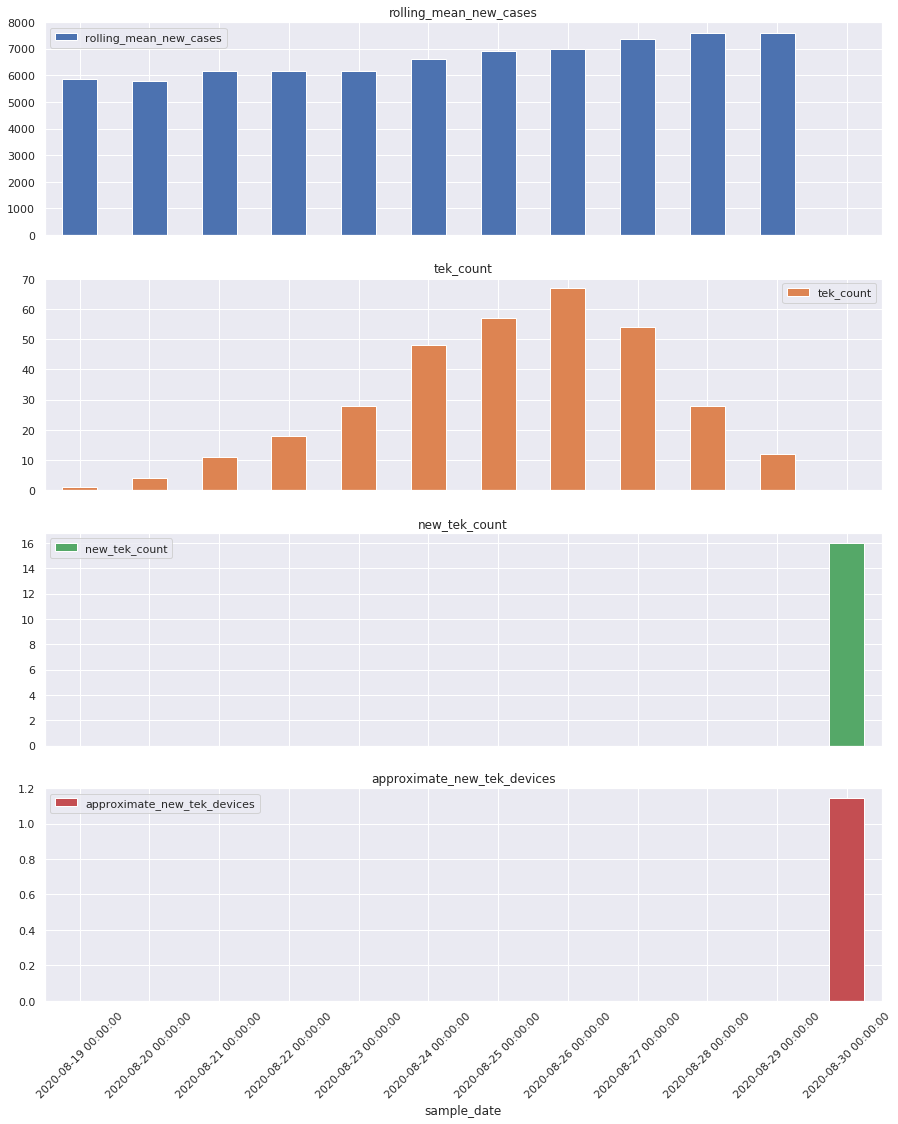

In [16]:
result_summary_df[
    ["rolling_mean_new_cases", "tek_count",
     "new_tek_count", "approximate_new_tek_devices"]].sort_index(ascending=True).plot.bar(
    rot=45, subplots=True, figsize=(15, 18))

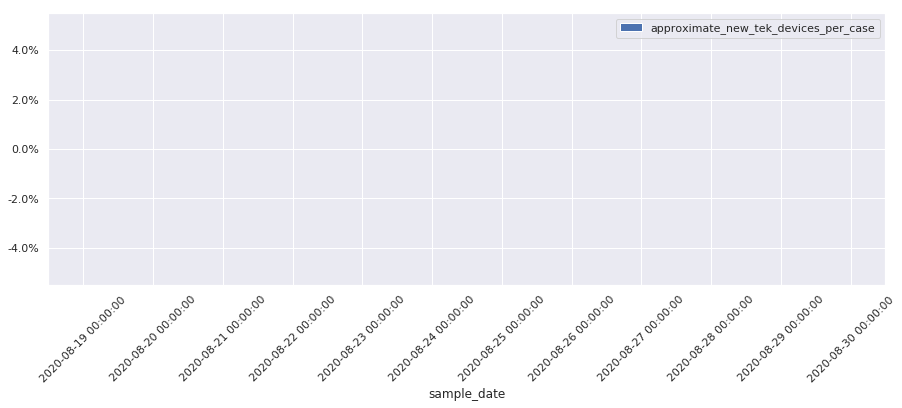

In [17]:
import matplotlib.ticker as mtick

ax = result_summary_df[
    ["approximate_new_tek_devices_per_case"]].sort_index(ascending=True).plot.bar(
    rot=45, figsize=(15, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))